In [10]:
from dataclasses import dataclass
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import seaborn as sns
from pathlib import Path
import numpy as np
import json
from matplotlib import patheffects
from utils import dref_dataframe, dump_dref
import matplotlib
from scipy import integrate
from statistics import stdev

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['savefig.facecolor'] = (0.0, 0.0, 0.0, 0.0)

sns.set_style("whitegrid")
sns.set_context("poster", font_scale=0.75)
sns.set_palette("colorblind6")


@dataclass
class BTimes:
    build: list[float]
    delay: list[float]
    clean: float | None
    drop: float
    cpu: dict[str, float]


def parse_frag(file: Path) -> pd.DataFrame:
    raw = file.read_text()
    data = ""
    for line in raw.splitlines():
        data += line + ((len(line) + 31) // 32 * 32 - len(line)) * "0"
    huge_pages = len(data)
    out = np.zeros(huge_pages)
    for i, char in enumerate(data):
        level = int(char)
        assert(0 <= level <= 9)
        out[i] = float(level)
    return pd.DataFrame(out)


def load_mode(max_mem: int, mode: str, path: Path, i=0) -> tuple[pd.DataFrame, BTimes]:
    data = pd.read_csv(path / f"out_{i}.csv")
    data["mode"] = mode
    if "time" not in data.columns:
        data["time"] = data.index
    if "total" not in data.columns:
        data["total"] = max_mem
    data["used"] = data["total"] - data["small"] * 2**12
    data["huge"] = data["total"] - data["huge"] * 2**(12+9)
    data["physical"] = data["rss"]

    data = data.melt(
        id_vars=["mode", "time"],
        var_name="measurement",
        value_name="bytes",
        value_vars=["physical", "used", "huge", "cached"])

    raw: dict = json.load((path / f"times_{i}.json").open())
    times = BTimes(
        x if isinstance(x := raw["build"], list) else [x],
        y if isinstance(y := raw["delay"], list) else [y],
        raw.get("clean"),
        raw["drop"] if "drop" in raw else raw["shrink"],
        raw["cpu"]
    )
    return data, times


def load_data(max_mem: int, modes: dict[str, Path]) -> tuple[pd.DataFrame, list[BTimes]]:
    datas: list[pd.DataFrame] = []
    times: list[BTimes] = []
    for mode, path in modes.items():
        data, time = load_mode(max_mem, mode, path)
        datas.append(data)
        times.append(time)
    data = pd.concat(datas, ignore_index=True)
    return data, times


def y_at(data: pd.DataFrame, x: float):
    return data[data["measurement"] == "physical"][(data["time"] - x).abs() < 2]["bytes"].max()


def calc_gib_min(data: pd.DataFrame, start: float, end: float) -> float:
    build_d = data[(start <= data["time"])
        & (data["time"] <= end)
        & (data["measurement"] == "physical")]
    return integrate.trapezoid(build_d["bytes"], x=build_d["time"]) / 1024**3 / 60


def relplot(max_mem: int, data: pd.DataFrame, times: list[BTimes], col_wrap=10, area=False, hide=list[int]) -> tuple[sns.FacetGrid, dict[str, float]]:
    data = data[(data["measurement"] == "physical") | (data["measurement"] == "used")]

    col_wrap = min(col_wrap, len(data["mode"].unique()))
    p = sns.relplot(data=data, kind="line", x="time", y="bytes", col="mode", col_wrap=col_wrap,
                    hue="measurement", height=5.5, legend=False)
    p.set_titles("{col_name}")

    modes = data["mode"].unique()
    extra_keys = {}

    h = list(p.axes[0].get_lines())
    l = list(data["measurement"].unique())
    p.add_legend(dict(zip(l, h)), loc="upper center", bbox_to_anchor=(0.41, 0.04), ncol=7, frameon=True)

    p.refline(y=max_mem, color=sns.crayons["Gray"])
    for i, time in enumerate(times):
        axis = p.facet_axis(0, i)
        celld = data[data["mode"] == modes[i]]

        tstart = 0
        j = 0
        prefix = ""
        for tbuild, tdelay in zip(time.build, time.delay):
            axis.axvspan(
                xmin=tstart, xmax=tbuild, ymax=0.91, edgecolor=sns.crayons["Gray"],
                facecolor="white", zorder=-1, hatch="//")

            b_mid = tstart + (tbuild - tstart)/2
            axis.text(b_mid, max_mem * 1.02, "runtime", horizontalalignment="center",
                        path_effects=[patheffects.withStroke(linewidth=5, foreground='white')])

            gib_m = calc_gib_min(celld, tstart, tbuild)
            print(f"{modes[i]}: {gib_m:.2f} GiB*m, {tbuild - tstart:.2f} s")
            extra_keys[f"{modes[i]}/{j}/run/gib_m"] = gib_m
            extra_keys[f"{modes[i]}/{j}/run/time"] = tbuild - tstart

            gib = y_at(celld, tbuild + (tdelay - tbuild)/2) / 1024**3
            prefix += f"delay {gib:.2f} GiB, "
            extra_keys[f"{modes[i]}/{j}/delay/gib"] = gib
            tstart = tdelay
            j += 1

        tdelay = time.delay[-1]
        if time.clean is not None:
            axis.annotate(
                "clean",
                (tdelay, y_at(celld, tdelay) + max_mem/32),
                (tdelay, max_mem * 0.925),
                horizontalalignment="center",
                path_effects=[patheffects.withStroke(linewidth=5, foreground='white')],
                arrowprops={"facecolor": sns.crayons["Violet (Purple)"]})
            tdelay = time.clean
            gib = y_at(celld, tdelay) / 1024**3
            prefix += f"clean {gib:.2f} GiB, "
            extra_keys[f"{modes[i]}/clean/gib"] = gib

        axis.annotate(
            "drop",
            (tdelay, y_at(celld, tdelay) + max_mem/32),
            (tdelay, max_mem * 0.85),
            horizontalalignment="center",
            path_effects=[patheffects.withStroke(linewidth=5, foreground='white')],
            arrowprops={"facecolor": "black"})
        gib = y_at(celld, time.drop) / 1024**3
        prefix += f"drop {gib:.2f} GiB, "
        extra_keys[f"{modes[i]}/drop/gib"] = gib

        gib_m = calc_gib_min(celld, 0, time.drop)
        prefix += f"{gib_m:.2f} GiB*m"
        extra_keys[f"{modes[i]}/gib_m"] = gib_m

        if area:
            axis.fill_between(
                x=axis.get_lines()[0].get_xdata(),
                y1=axis.get_lines()[0].get_ydata(),
                y2=axis.get_lines()[1].get_ydata(),
                color="yellow")

        if i in hide:
            axis.clear()
            axis.set_axis_off()

        print(f"{modes[i]}: {prefix}")

    p.set(ylabel="Memory consumption [GiB]")
    p.set(xlabel="Time [seconds]")
    p.set(ylim=(0, max_mem * 1.1))
    p.set(yticks=[x for x in range(0, max_mem + 1, 2*1024**3)],
        yticklabels=[str(x // 1024**3) for x in range(0, max_mem + 1, 2*1024**3)])
    p.set(facecolor="white")

    return p, extra_keys


def visualize(max_mem: int, modes: dict[str, Path], save_as: str | None = None, col_wrap=10, area=False, hide=list[int], dref=True) -> sns.FacetGrid:
    data, times = load_data(max_mem, modes)
    p, extra_keys = relplot(max_mem, data, times, col_wrap=col_wrap, area=area, hide=hide)
    if save_as:
        p.savefig(Path("compiling") / f"{save_as}.pdf")
        p.savefig(Path("compiling") / f"{save_as}.svg")
        if dref:
            dref_dataframe(save_as, Path("compiling"), ["mode", "measurement", "time"], data)
            with (Path("compiling") / f"{save_as}_extra.dref").open("w+") as f:
                dump_dref(f, save_as, extra_keys)
    return p



def parse_inflate(path: Path, iter: int = 1) -> pd.DataFrame:
    meta = json.load((path / f"meta.json").open())
    data = pd.read_csv(path / "out.csv")
    data["iter"] = data.index
    data["shrink"] = (data["shrink"] / 1e9) / meta["args"]["mem"]
    data["grow"] = (data["grow"] / 1e9) / meta["args"]["mem"]
    if "touch" in data.columns:
        data["touch"] = (data["touch"] / 1e9) / (meta["args"]["mem"] - 1)
    if "touch" in data.columns:
        data["touch2"] = (data["touch2"] / 1e9) / (meta["args"]["mem"] - 1)

    match path.stem:
        case n if n.endswith("base-manual"): mode = "virtio-balloon"
        case n if n.endswith("huge-manual"): mode = "virtio-balloon-huge"
        case n if n.endswith("virtio-mem-movable"): mode = "virtio-mem"
        case n if n.endswith("virtio-mem-movable-vfio"): mode = "virtio-mem+VFIO"
        case n if n.endswith("llfree-manual"): mode = "HyperAlloc"
        case n if n.endswith("llfree-manual-vfio"): mode = "HyperAlloc+VFIO"
        case m: mode = m
    data["mode"] = mode
    return pd.DataFrame(data)


virtio-balloon: 430.61 GiB*m, 2477.07 s
virtio-balloon: delay 12.22 GiB, clean 11.55 GiB, drop 7.99 GiB, 538.36 GiB*m
HyperAlloc: 357.68 GiB*m, 2447.11 s
HyperAlloc: delay 10.62 GiB, clean 6.86 GiB, drop 1.90 GiB, 422.96 GiB*m


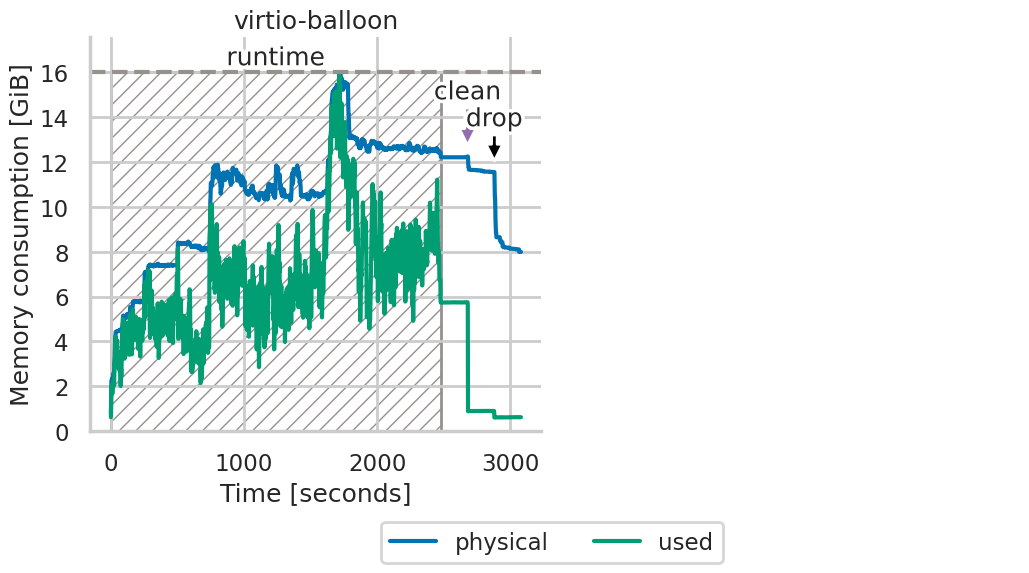

In [11]:
max_mem = 16*1024**3
p = visualize(max_mem, {
    "virtio-balloon": Path("compiling/latest-clang-base-auto"),
    "HyperAlloc": Path("compiling/latest-clang-llfree-auto"),
}, "talk-clang-0", hide=[1], dref=False)


virtio-balloon: 430.61 GiB*m, 2477.07 s
virtio-balloon: delay 12.22 GiB, clean 11.55 GiB, drop 7.99 GiB, 538.36 GiB*m
HyperAlloc: 357.68 GiB*m, 2447.11 s
HyperAlloc: delay 10.62 GiB, clean 6.86 GiB, drop 1.90 GiB, 422.96 GiB*m


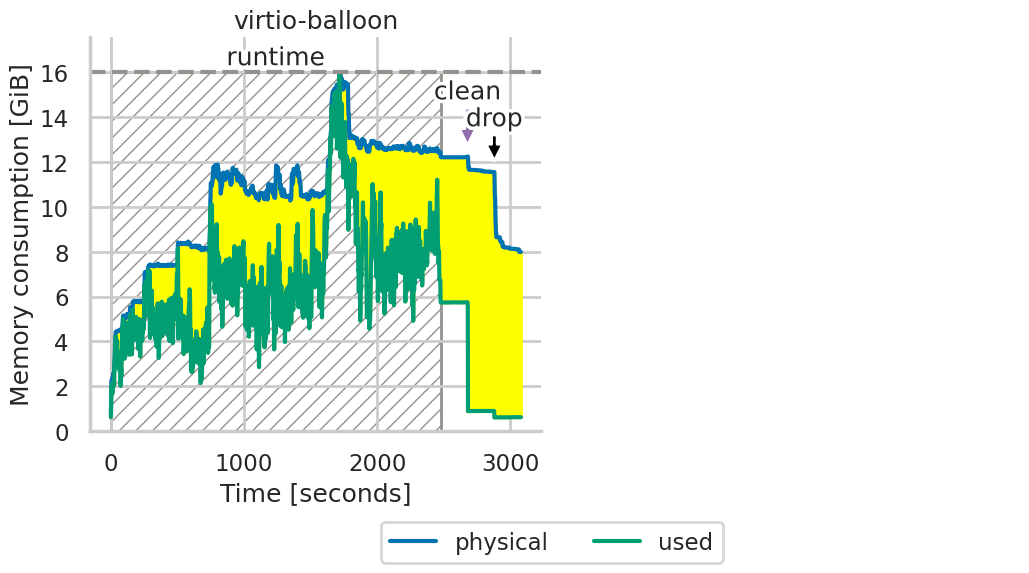

In [12]:
max_mem = 16*1024**3
p = visualize(max_mem, {
    "virtio-balloon": Path("compiling/latest-clang-base-auto"),
    "HyperAlloc": Path("compiling/latest-clang-llfree-auto"),
}, "talk-clang-1", area=True, hide=[1], dref=False)


virtio-balloon: 430.61 GiB*m, 2477.07 s
virtio-balloon: delay 12.22 GiB, clean 11.55 GiB, drop 7.99 GiB, 538.36 GiB*m
HyperAlloc: 357.68 GiB*m, 2447.11 s
HyperAlloc: delay 10.62 GiB, clean 6.86 GiB, drop 1.90 GiB, 422.96 GiB*m


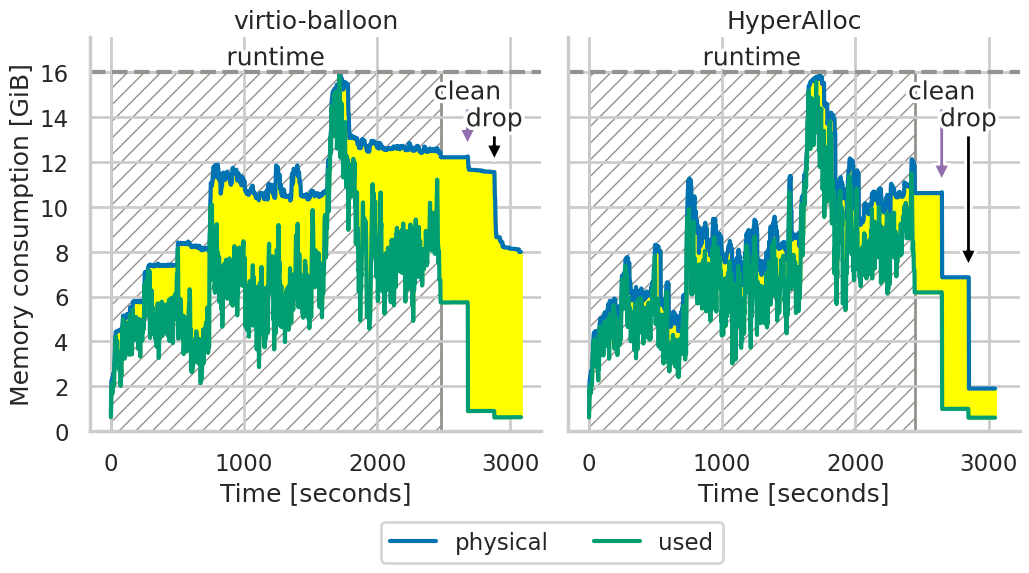

In [13]:
max_mem = 16*1024**3
p = visualize(max_mem, {
    "virtio-balloon": Path("compiling/latest-clang-base-auto"),
    "HyperAlloc": Path("compiling/latest-clang-llfree-auto"),
}, "talk-clang", area=True)


virtio-balloon: 430.61 GiB*m, 2477.07 s
virtio-balloon: delay 12.22 GiB, clean 11.55 GiB, drop 7.99 GiB, 538.36 GiB*m
HyperAlloc: 357.68 GiB*m, 2447.11 s
HyperAlloc: delay 10.62 GiB, clean 6.86 GiB, drop 1.90 GiB, 422.96 GiB*m


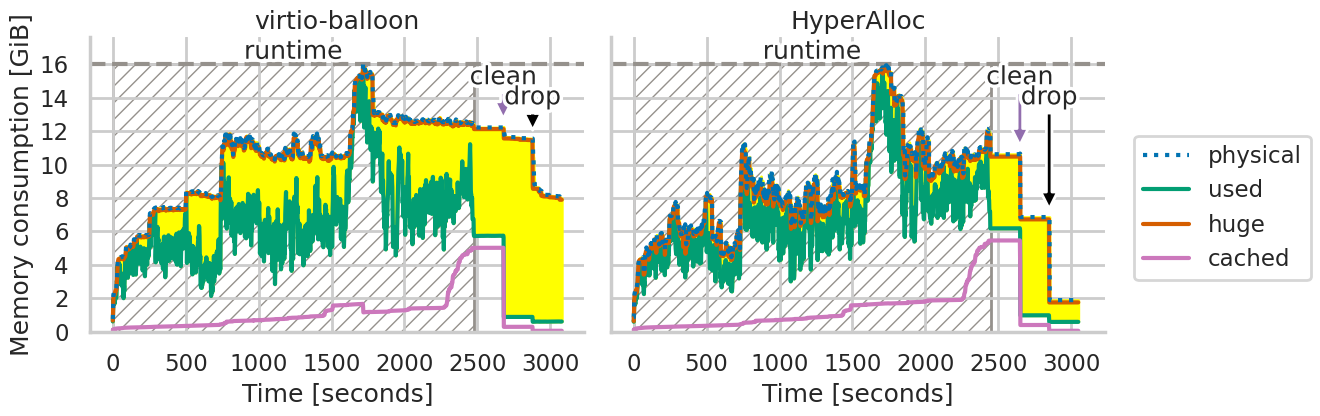

In [14]:
def relplot(max_mem: int, data: pd.DataFrame, times: list[BTimes], col_wrap=10, area=False, hide=list[int]) -> tuple[sns.FacetGrid, dict[str, float]]:
    col_wrap = min(col_wrap, len(data["mode"].unique()))
    p = sns.relplot(data=data, kind="line", x="time", y="bytes", col="mode", col_wrap=col_wrap,
                    hue="measurement", height=4.5, aspect=1.3, legend=False)
    p.set_titles("{col_name}")

    modes = data["mode"].unique()
    extra_keys = {}

    for ax in p.axes:
        ax.get_lines()[0].set(zorder=10, linestyle="dotted")

    h = list(p.axes[0].get_lines())
    l = list(data["measurement"].unique())
    p.add_legend(dict(zip(l, h)), loc="right", bbox_to_anchor=(1.0, 0.5), frameon=True)

    p.refline(y=max_mem, color=sns.crayons["Gray"])
    for i, time in enumerate(times):
        axis = p.facet_axis(0, i)
        celld = data[data["mode"] == modes[i]]

        tstart = 0
        j = 0
        prefix = ""
        for tbuild, tdelay in zip(time.build, time.delay):
            axis.axvspan(
                xmin=tstart, xmax=tbuild, ymax=0.91, edgecolor=sns.crayons["Gray"],
                facecolor="white", zorder=-1, hatch="//")

            b_mid = tstart + (tbuild - tstart)/2
            axis.text(b_mid, max_mem * 1.02, "runtime", horizontalalignment="center",
                        path_effects=[patheffects.withStroke(linewidth=5, foreground='white')]
                    )

            gib_m = calc_gib_min(celld, tstart, tbuild)
            print(f"{modes[i]}: {gib_m:.2f} GiB*m, {tbuild - tstart:.2f} s")
            extra_keys[f"{modes[i]}/{j}/run/gib_m"] = gib_m
            extra_keys[f"{modes[i]}/{j}/run/time"] = tbuild - tstart

            gib = y_at(celld, tbuild + (tdelay - tbuild)/2) / 1024**3
            prefix += f"delay {gib:.2f} GiB, "
            extra_keys[f"{modes[i]}/{j}/delay/gib"] = gib
            tstart = tdelay
            j += 1

        tdelay = time.delay[-1]
        if time.clean is not None:
            axis.annotate(
                "clean",
                (tdelay, y_at(celld, tdelay) + max_mem/32),
                (tdelay, max_mem * 0.925),
                horizontalalignment="center",
                path_effects=[patheffects.withStroke(linewidth=5, foreground='white')],
                arrowprops={"facecolor": sns.crayons["Violet (Purple)"]})
            tdelay = time.clean
            gib = y_at(celld, tdelay) / 1024**3
            prefix += f"clean {gib:.2f} GiB, "
            extra_keys[f"{modes[i]}/clean/gib"] = gib

        axis.annotate(
            "drop",
            (tdelay, y_at(celld, tdelay) + max_mem/32),
            (tdelay, max_mem * 0.85),
            horizontalalignment="center",
            path_effects=[patheffects.withStroke(linewidth=5, foreground='white')],
            arrowprops={"facecolor": "black"})
        gib = y_at(celld, time.drop) / 1024**3
        prefix += f"drop {gib:.2f} GiB, "
        extra_keys[f"{modes[i]}/drop/gib"] = gib

        gib_m = calc_gib_min(celld, 0, time.drop)
        prefix += f"{gib_m:.2f} GiB*m"
        extra_keys[f"{modes[i]}/gib_m"] = gib_m

        if area:
            axis.fill_between(
                x=axis.get_lines()[0].get_xdata(),
                y1=axis.get_lines()[0].get_ydata(),
                y2=axis.get_lines()[1].get_ydata(),
                color="yellow")

        if i in hide:
            axis.clear()
            axis.set_axis_off()

        print(f"{modes[i]}: {prefix}")

    p.set(ylabel="Memory consumption [GiB]")
    p.set(xlabel="Time [seconds]")
    p.set(ylim=(0, max_mem * 1.1))
    p.set(yticks=[x for x in range(0, max_mem + 1, 2*1024**3)],
        yticklabels=[str(x // 1024**3) for x in range(0, max_mem + 1, 2*1024**3)])
    p.set(facecolor="white")

    return p, extra_keys


max_mem = 16*1024**3
p = visualize(max_mem, {
    "virtio-balloon": Path("compiling/latest-clang-base-auto"),
    "HyperAlloc": Path("compiling/latest-clang-llfree-auto"),
}, "poster-clang", area=True)


['Reclaim' 'Return' 'Install' 'Return + Install' 'Reclaim Untouched']
8577.31506022133


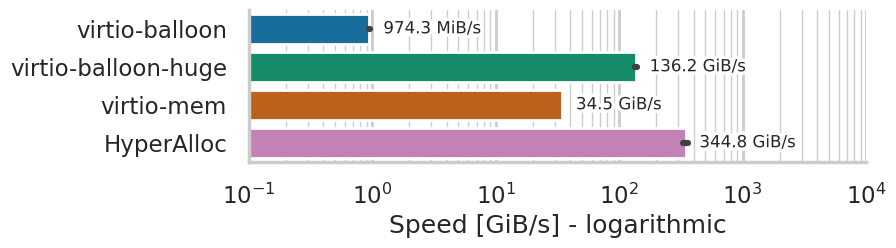

In [36]:
# Touched
paths = [
    Path("inflate/latest-base-manual"),
    Path("inflate/latest-huge-manual"),
    Path("inflate/latest-virtio-mem-movable"),
    # Path("inflate/latest-virtio-mem-movable-vfio"),
    Path("inflate/latest-llfree-manual"),
    # Path("inflate/latest-llfree-manual-vfio"),
]

data = pd.concat([parse_inflate(p, 3) for p in paths])
data = data[data["iter"] > 0]
data["install"] = data["touch"] + data["grow"]
# print(data)
max_access = (1 / data["touch2"]).max()

pgd = data.melt(id_vars=["mode", "iter"], value_vars=["shrink", "grow", "touch", "install"],
                var_name="op", value_name="time")
pgd["time"] = 1 / pgd["time"]

# Untouched
paths = [
    Path("inflate/latest-nofault-base-manual"),
    Path("inflate/latest-nofault-huge-manual"),
    Path("inflate/latest-nofault-virtio-mem-movable"),
    # Path("inflate/latest-nofault-virtio-mem-movable-vfio"),
    Path("inflate/latest-nofault-llfree-manual"),
    # Path("inflate/latest-nofault-llfree-manual-vfio"),
]

data = pd.concat([parse_inflate(p, 3) for p in paths])
data = data[data["iter"] > 0]
# print(data)

pgd1 = data.melt(id_vars=["mode", "iter"], value_vars=["shrink", "grow"],
                var_name="op", value_name="time")
pgd1["time"] = 1 / pgd1["time"]
pgd1 = pgd1[pgd1["op"] == "shrink"]
pgd1["op"] = "Reclaim Untouched"

# Both
pgd = pd.concat([pgd, pgd1])
pgd.loc[pgd["op"] == "shrink", "op"] = "Reclaim"
pgd.loc[pgd["op"] == "grow", "op"] = "Return"
pgd.loc[pgd["op"] == "install", "op"] = "Return + Install"
pgd.loc[pgd["op"] == "touch", "op"] = "Install"
print(pgd["op"].unique())

# pgd = pgd[pgd["op"] == "Reclaim"]

print(pgd["time"].max())
order = ["virtio-balloon","virtio-balloon-huge","virtio-mem","HyperAlloc"]
# order = ["virtio-balloon","virtio-balloon-huge","virtio-mem","virtio-mem+VFIO","HyperAlloc","HyperAlloc+VFIO"]
p = sns.FacetGrid(pgd, row="op", margin_titles=True,
                  row_order=["Reclaim"],
                  aspect=3.5, height=3, sharex=True)

p.map_dataframe(sns.barplot, y="mode", hue="mode", hue_order=order,
                palette="colorblind6", x="time", dodge=False)
p.set(ylabel=None)

def mem_fmt(x: float) -> str:
    x *= 1024**3
    sizes = ["TiB", "GiB", "MiB", "KiB"]
    for i, suffix in enumerate(sizes):
        mul = 1024 ** (len(sizes) - i)
        if x > mul: return f"{x/mul:.1f} {suffix}/s"
    return f"{x:.2} B/s"

for key, ax in p.axes_dict.items():
    if key != "Return + Install":
        ax.set(xlim=(1e-1, 1e4))
        ax.set_xscale("log", base=10)
        ax.set(xlabel="Speed [GiB/s] - logarithmic")
    else:
        ax.set(xlim=(0, 6))
        ax.set(xlabel="Speed [GiB/s] - linear")

    ax.grid(True, which="minor", linewidth=1)
    for c in ax.containers:
        ax.bar_label(c, fmt=mem_fmt, fontsize=12, padding=10,
                     path_effects=[patheffects.withStroke(linewidth=5, foreground='white')])
p.set_titles(row_template="")
p.figure.savefig("inflate/talk-inflate.pdf", bbox_inches="tight")
p.figure.savefig("inflate/talk-inflate.svg", bbox_inches="tight")


In [37]:
""

''